## Blue Book for Bulldozers
### Description
Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.

We are going to predict the sale price of bulldozers sold at auctions.

The data is split into 3 parts:
- Train.csv is the training set, which contains data through the end of 2011.
- Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale


### Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

### Imports

In [55]:
# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Reading and exploring the data

Since we have a date column, we can parse it to have a datetime data type, for better usage.

In [123]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

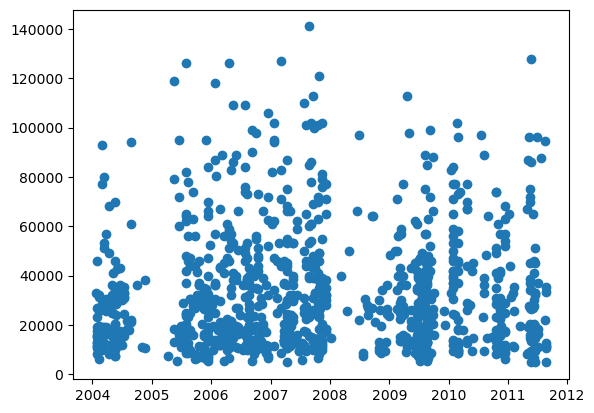

In [3]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])
plt.show()

Since we are working with a time series, it can be useful to sort the dataframe based on the salesdate

In [124]:
df.sort_values(by=['saledate'], ascending=True, inplace=True)
df_test.sort_values(by=['saledate'], ascending=True, inplace=True)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


We can observe some trends on the sales related to the dates, in some years it appears to have more sales by the end of the year, others have more sales on the first semester, and some years have only a few sales. It can be useful for our model to create some additional features related to when the bulldozer was sold: Year, Month, day, day of week, and day of month.

In [125]:
# First, let's make a copy of the dataframe, so we can keep the original one
df_temp = df.copy()

In [126]:
def add_date_features(df):
    df['saleYear'] = df['saledate'].dt.year
    df['saleMonth'] = df['saledate'].dt.month
    df['saleDay'] = df['saledate'].dt.day
    df['saleDayOfWeek'] = df['saledate'].dt.day_of_week
    df['saleDayOfYear'] = df['saledate'].dt.day_of_year
    df['saleInQuarterStart'] = df['saledate'].dt.is_quarter_start
    df['saleInQuarterEnd'] = df['saledate'].dt.is_quarter_end
    df['saleInYearStart'] = df['saledate'].dt.is_year_start
    df['saleInYearEnd'] = df['saledate'].dt.is_year_end

add_date_features(df_temp)
add_date_features(df_test)
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,saleInQuarterStart,saleInQuarterEnd,saleInYearStart,saleInYearEnd
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,1989,1,17,1,17,False,False,False,False
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,Conventional,1989,1,31,1,31,False,False,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,1989,1,31,1,31,False,False,False,False
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,Conventional,1989,1,31,1,31,False,False,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,1989,1,31,1,31,False,False,False,False


### Visualizing the data

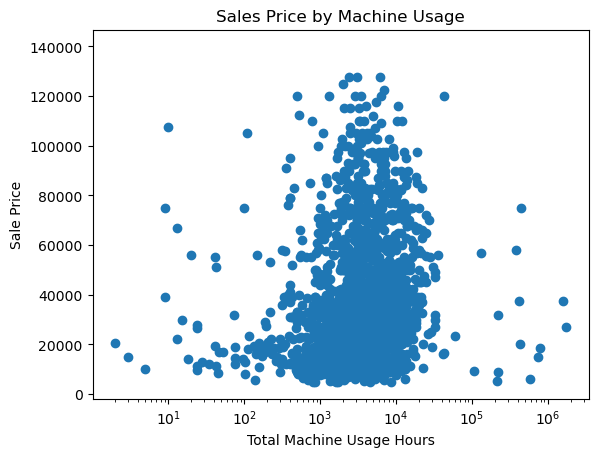

In [8]:
# since we have over 400k data points, we can use a fraction of the data (10k), for better visualization
df_sample = df_temp.sample(frac=0.025, random_state=42)

fig, ax = plt.subplots()
# ax.scatter(df_temp['MachineHoursCurrentMeter'], df_temp['SalePrice'])
ax.scatter(df_sample['MachineHoursCurrentMeter'], df_sample['SalePrice'])
plt.xscale("log")
plt.title("Sales Price by Machine Usage")
plt.ylabel("Sale Price")
plt.xlabel("Total Machine Usage Hours")
plt.show()

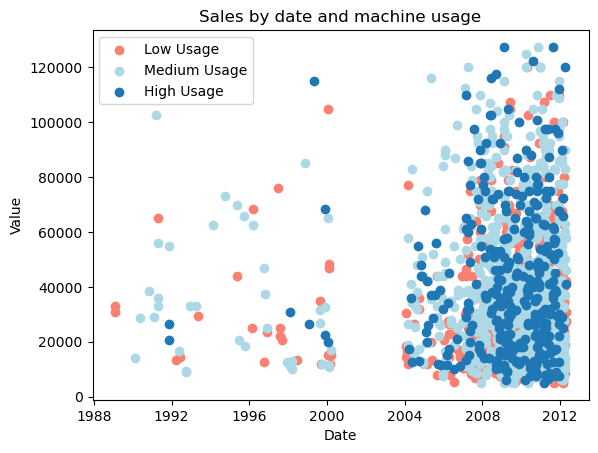

In [9]:

fig, ax = plt.subplots()

ax.scatter(df_sample.saledate[df_sample.UsageBand == 'Low'], df_sample.SalePrice[df_sample.UsageBand == 'Low'], c='salmon')
ax.scatter(df_sample.saledate[df_sample.UsageBand == 'Medium'], df_sample.SalePrice[df_sample.UsageBand == 'Medium'], c='lightblue')
ax.scatter(df_sample.saledate[df_sample.UsageBand == 'High'], df_sample.SalePrice[df_sample.UsageBand == 'High'])

plt.title("Sales by date and machine usage")
plt.legend(['Low Usage', 'Medium Usage', 'High Usage'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

It's interesting to note that most of the machines sold (and with the higher prices) are in the range of 1000 to 10000 hours of usage. Maybe people who buy bulldozers are more confident in buying products that already have some usage (a explanation for this could be that new bulldozers may think that's risky to buy new bulldozers, maybe they can present some defects), but not too much, since they may have a lower useful life.

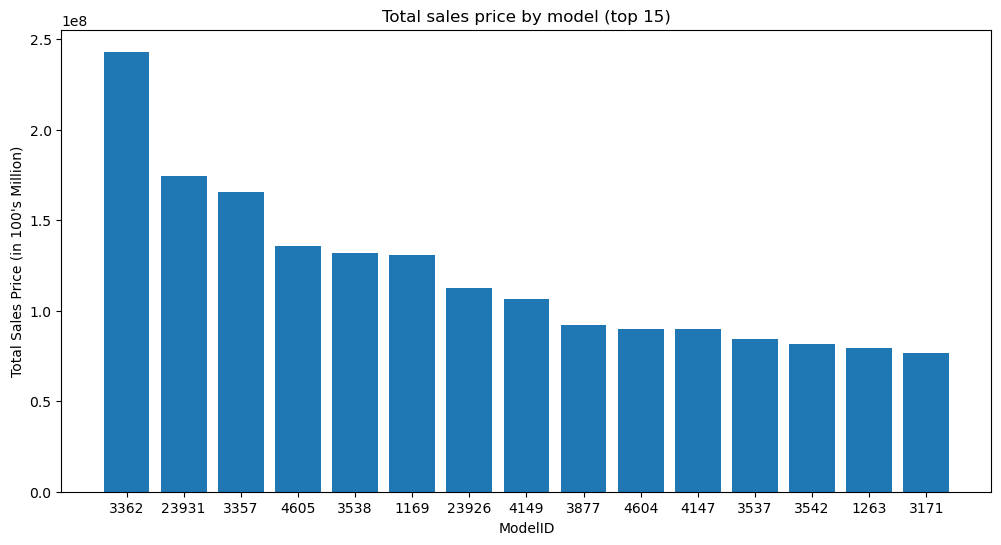

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))

df_plt = df_temp["SalePrice"].groupby(df_temp["ModelID"]).sum().sort_values(ascending=False)
df_plt.index = df_plt.index.astype(str)

ax.bar(df_plt.index[:15], df_plt.values[:15])

plt.xlabel("ModelID")
plt.ylabel("Total Sales Price (in 100's Million)")
plt.title("Total sales price by model (top 15)")
plt.show()

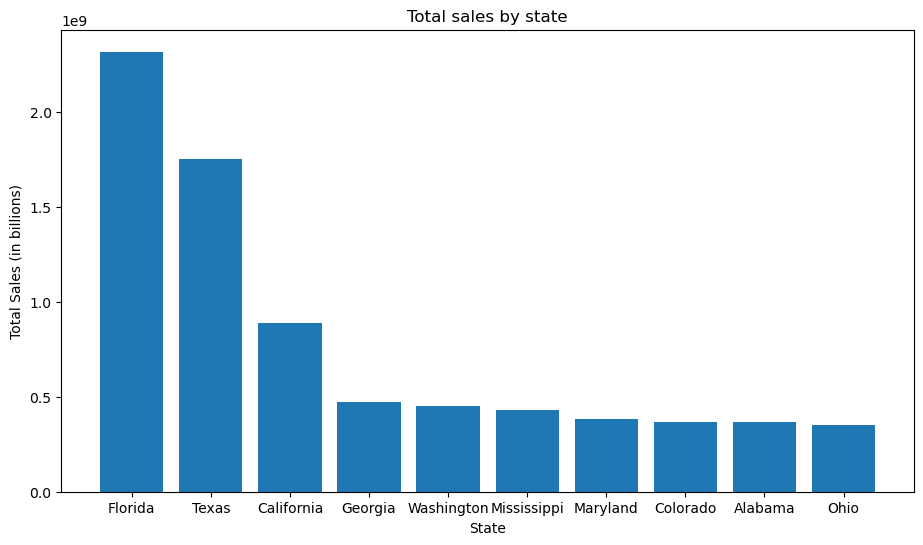

In [80]:
fig, ax = plt.subplots(figsize=(11, 6))

df_plt = df_temp["SalePrice"].groupby(df_temp["state"]).sum().sort_values(ascending=False)

ax.bar(df_plt.index[:10], df_plt.values[:10])
plt.xlabel('State')
plt.ylabel('Total Sales (in billions)')
plt.title('Total sales by state')
plt.show()

### Missing Data:
For numerical missing values, we are going to use data imputation with the median of the column.

For categorical missing values, we are going to input a standard value, in this case "0000"

In [86]:
pd.set_option('display.max_rows', None)
print(df_temp.isna().sum())

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [87]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 62 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

First, we are going to convert some datatypes: MachineID, datasource, ModelID, and auctioneerID are going to be converted to category. Also, columns that have string values, are going to be converted to category, and then converted to dummies.

#### Numeric Data

In [127]:
def convert_columns(df):
    df.drop(columns="SalesID", inplace=True)
    cols = ["MachineID", "datasource", "ModelID", "auctioneerID"]

    for col in cols:
        df[col] = df[col].astype('category')

convert_columns(df_temp)
convert_columns(df_test)

In [94]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 61 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalePrice                 412698 non-null  float64       
 1   MachineID                 412698 non-null  category      
 2   ModelID                   412698 non-null  category      
 3   datasource                412698 non-null  category      
 4   auctioneerID              392562 non-null  category      
 5   YearMade                  412698 non-null  int64         
 6   MachineHoursCurrentMeter  147504 non-null  float64       
 7   UsageBand                 73670 non-null   object        
 8   saledate                  412698 non-null  datetime64[ns]
 9   fiModelDesc               412698 non-null  object        
 10  fiBaseModel               412698 non-null  object        
 11  fiSecondaryDesc           271971 non-null  object        
 12  fi

In [95]:
numeric_cols = df_temp.select_dtypes(include='number')
df_temp[numeric_cols.columns].isna().sum()

SalePrice                        0
YearMade                         0
MachineHoursCurrentMeter    265194
saleYear                         0
saleMonth                        0
saleDay                          0
saleDayOfWeek                    0
saleDayOfYear                    0
dtype: int64

In [128]:
def fill_numeric_missing_data(df):
    cols = df.select_dtypes(include="number")
    for col in cols.columns:
        if df[col].isna().sum():
            # register which elements were inputed
            df[col + "_is_missing"] = df[col].isna()
            # fill missing data
            df[col].fillna(df[col].median(), inplace=True)

fill_numeric_missing_data(df_temp)
fill_numeric_missing_data(df_test)

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_7356\3770391440.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_7356\3770391440.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [101]:
df_temp[numeric_cols.columns].isna().sum()

SalePrice                   0
YearMade                    0
MachineHoursCurrentMeter    0
saleYear                    0
saleMonth                   0
saleDay                     0
saleDayOfWeek               0
saleDayOfYear               0
dtype: int64

#### Categorical Data

In [131]:
def convert_categorical_cols(df):
    cols = df.select_dtypes(include=object)
    for col in cols:
        df[col] = df[col].astype('category')

convert_categorical_cols(df_temp)
convert_categorical_cols(df_test)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 62 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   SalePrice                            412698 non-null  float64       
 1   MachineID                            412698 non-null  category      
 2   ModelID                              412698 non-null  category      
 3   datasource                           412698 non-null  category      
 4   auctioneerID                         392562 non-null  category      
 5   YearMade                             412698 non-null  int64         
 6   MachineHoursCurrentMeter             412698 non-null  float64       
 7   UsageBand                            73670 non-null   category      
 8   saledate                             412698 non-null  datetime64[ns]
 9   fiModelDesc                          412698 non-null  category      
 

In [132]:
def convert_to_numeric(df):
    cols = df.select_dtypes(include='category')
    for col in cols:
        if df[col].isna().sum():
            df[col + "_is_missing"] = df[col].isna()

        df[col] = pd.Categorical(df[col]).codes + 1

convert_to_numeric(df_temp)
convert_to_numeric(df_test)
df_temp.head()

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,9500.0,103167,1692,2,19,1974,0.0,0,1989-01-17,4593,...,True,True,True,True,True,False,False,False,True,True
274835,14000.0,133113,2094,2,30,1980,0.0,0,1989-01-31,1820,...,True,True,True,True,True,True,True,True,False,False
141296,50000.0,258856,907,2,30,1978,0.0,0,1989-01-31,2348,...,True,True,True,True,True,False,False,False,True,True
212552,16000.0,192945,1731,2,30,1980,0.0,0,1989-01-31,1819,...,True,True,True,True,True,True,True,True,False,False
62755,22000.0,196778,882,2,30,1984,0.0,0,1989-01-31,2119,...,True,True,True,True,True,False,False,False,True,True


Before saving the new datasets, we can remove the saledate column, since we are using other columns to represet the data

In [133]:
def drop_saledate(df):
    df.drop(columns="saledate", inplace=True)

drop_saledate(df_temp)
drop_saledate(df_test)
df_temp.head()

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,9500.0,103167,1692,2,19,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,14000.0,133113,2094,2,30,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,50000.0,258856,907,2,30,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,16000.0,192945,1731,2,30,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,22000.0,196778,882,2,30,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [134]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 100 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalePrice                            412698 non-null  float64
 1   MachineID                            412698 non-null  int32  
 2   ModelID                              412698 non-null  int16  
 3   datasource                           412698 non-null  int8   
 4   auctioneerID                         412698 non-null  int8   
 5   YearMade                             412698 non-null  int64  
 6   MachineHoursCurrentMeter             412698 non-null  float64
 7   UsageBand                            412698 non-null  int8   
 8   fiModelDesc                          412698 non-null  int16  
 9   fiBaseModel                          412698 non-null  int16  
 10  fiSecondaryDesc                      412698 non-null  int16  
 11  fiModelSerie

In [135]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12457 entries, 1408 to 9803
Data columns (total 98 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MachineID                            12457 non-null  int16  
 1   ModelID                              12457 non-null  int16  
 2   datasource                           12457 non-null  int8   
 3   auctioneerID                         12457 non-null  int8   
 4   YearMade                             12457 non-null  int64  
 5   MachineHoursCurrentMeter             12457 non-null  float64
 6   UsageBand                            12457 non-null  int8   
 7   fiModelDesc                          12457 non-null  int16  
 8   fiBaseModel                          12457 non-null  int16  
 9   fiSecondaryDesc                      12457 non-null  int8   
 10  fiModelSeries                        12457 non-null  int8   
 11  fiModelDescriptor              

In [137]:
set(df_temp) - set(df_test)

{'SalePrice', 'auctioneerID_is_missing'}

In [138]:
df_test["auctioneerID_is_missing"] = False

### Saving the preprocessed data

In [139]:
df_temp.to_csv("data/train_preprocessed.csv", index=False)
df_test.to_csv("data/test_preprovessed.csv", index=False)